# Przewidywanie ilości pyłów w dużych miastach Chin




In [4]:
## Wstęp

Notebook zawiera projekt dotyczący przedmiotu probabilistycznych modeli grafowych.

Celem projektu jest wykorzystanie w praktyce wiedzy zdobytej w trakcie laboratoriów z tematyki
modeli probabilistycznych. Należało wykorzystać minimum jeden prosty model i jeden bardziej złożony.

Problemem, który jest w tym projekcie rozwiązywany jest przewidywanie ilości pyłów na podstawie danych atmosferycznych, dacie i lokalizacji.

Dane z których będziemy korzystać można znaleźć pod tym adresem [archive-ics](https://archive.ics.uci.edu/ml/datasets/PM2.5+Data+of+Five+Chinese+Cities).

Link do artykułu na temat danych [link](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1002/2016JD024877)

## Eksploracyjna analiza danych

Pierwszym etapem kazdego projektu związanego z analizą danych jest zaimportowanie wymaganych bibliotek i pobranie danych. Zostałe one już pobrane lokalnie do folderu `data`. W związku z tym, że dane są rozbite na pięć plików, kazdy na jedno miasto, zdecydowaliśmy się wybrać jedno z nich - miasto 'Beijing'. 

In [5]:
import pandas as pd
import math
from pandas_profiling import ProfileReport

from sklearn.preprocessing import StandardScaler, OneHotEncoder
import numpy as np

import warnings
warnings.filterwarnings("ignore")
import seaborn as sns, matplotlib.pyplot as plt

beijing = pd.read_csv('data/BeijingPM20100101_20151231.csv')

Co jest istotne w zbiorze to fakt, iż pomimo, że jest to jedno miasto, pyły były pobierane z kilku miejsc w mieście. Lokalizacje tych punktów z czujnikami można zobaczyc na poniższym obrazku. 

Zbiór danych oryginalnie posiadał **52584 rekordów** oraz **18 zmiennych**.

Po wstępnym przetwarzaniu danych, pozostało **19062 rekordów** oraz **14 cech**.

| ![mapa lokalizacji czujników w poszczególnych miastach](./results/chiny-minimapa.jpg) | 
|:--:| 
| *Mapa lokalizacji czujników w poszczególnych miastach Chińskich*|

Tutaj należałoby przytoczyć co oznacza każda ze zmiennych i jakiego jest ona typu. Ponadto w tabeli podano operacje jakim zostały poddane w trakcie preprocessingu.

 | Nazwa kolumny | Typ zmiennej | Opis zmiennej | Operacja |
 | --- | --- | --- | --- |
 |`No`| brak | numer wiersza | Usunięcie |
 | `year`| kategoryczna | rok zebrania próbki | Wybrana do modelu |
 | `month`| kategoryczna | miesiąc zebrania próbki | Wybrana do modelu |
 | `day`| kategoryczna | dzień zebrania próbki | Usunięcie |
 | `hour`| kategoryczna | godzina danych w tym wierszu | Wybrana do modelu |
 | `season`| kategoryczna | sezon danych w tym wierszu | Usunięta |
 | `PM_Dongsi`| ciągła / predykowana | stężenie PM2,5 (ug / m ^ 3) wykryta w czujniku w lokalizacji Dongsi | Usuwanie pustych wartości i wybrana do modelu |
 | `PM_Dongsihuan`| ciągła / predykowana | stężenie PM2,5 (ug / m ^ 3) wykryta w czujniku w lokalizacji Dongsihuan | Usuwanie pustych wartości i wybrana do modelu|
 | `PM_Nongzhanguan`| ciągła / predykowana | stężenie PM2,5 (ug / m ^ 3) wykryta w czujniku w lokalizacji Nongzhanguan | Usuwanie pustych wartości i wybrana do modelu|
 | `PM_US Post`| ciągła / predykowana | stężenie PM2,5 (ug / m ^ 3) wykryta w czujniku w ambasadzie Stanów Zjednoczonych  | Usuwanie pustych wartości i wybrana do modelu|
 | `DEWP`| ciągła | punkt rosy (stopnie Celsjusza) | Standaryzacja i wybrana do modelu|
 | `HUMI`| ciągła | wilgotność (%) | Standaryzacja i wybrana do modelu |
 | `PRES`| ciągła | ciśnienie (hPa) | Standaryzacja i wybrana do modelu |
 | `TEMP`| ciągła | temperatura (stopnie Celsjusza) | Standaryzacja i wybrana do modelu|
 | `cbwd`| kategoryczna | Połączony kierunek wiatru | Wybrana do modelu |
 | `Iws`| ciągła | skumulowana prędkość wiatru (m / s) | Standaryzacja i wybrana do modelu |
 | `precipitation`| ciągła | opad godzinowy (mm) | Usunięta |
 | `Iprec`| ciągła | skumulowany opad (mm) | Standaryzacja i wybrana do modelu |

Teraz należałoby spojrzec co właściwe jest w tych danych. Do tego zostały zastosowane metody `head` i `tail`

In [6]:
beijing.head()

,No,year,month,day,hour,season,PM_Dongsi,PM_Dongsihuan,PM_Nongzhanguan,PM_US Post,DEWP,HUMI,PRES,TEMP,cbwd,Iws,precipitation,Iprec
0,1,2010,1,1,0,4,NaN,NaN,NaN,NaN,-21.0,43.0,1021.0,-11.0,NW,1.79,0.0,0.0
1,2,2010,1,1,1,4,NaN,NaN,NaN,NaN,-21.0,47.0,1020.0,-12.0,NW,4.92,0.0,0.0
2,3,2010,1,1,2,4,NaN,NaN,NaN,NaN,-21.0,43.0,1019.0,-11.0,NW,6.71,0.0,0.0
3,4,2010,1,1,3,4,NaN,NaN,NaN,NaN,-21.0,55.0,1019.0,-14.0,NW,9.84,0.0,0.0
4,5,2010,1,1,4,4,NaN,NaN,NaN,NaN,-20.0,51.0,1018.0,-12.0,NW,12.97,0.0,0.0


In [7]:
beijing.tail()

,No,year,month,day,hour,season,PM_Dongsi,PM_Dongsihuan,PM_Nongzhanguan,PM_US Post,DEWP,HUMI,PRES,TEMP,cbwd,Iws,precipitation,Iprec
52579,52580,2015,12,31,19,4,140.0,157.0,122.0,133.0,-8.0,68.0,1031.0,-3.0,SE,7.14,0.0,0.0
52580,52581,2015,12,31,20,4,157.0,199.0,149.0,169.0,-8.0,63.0,1030.0,-2.0,SE,8.03,0.0,0.0
52581,52582,2015,12,31,21,4,171.0,231.0,196.0,203.0,-10.0,73.0,1030.0,-6.0,NE,0.89,0.0,0.0
52582,52583,2015,12,31,22,4,204.0,242.0,221.0,212.0,-10.0,73.0,1030.0,-6.0,NE,1.78,0.0,0.0
52583,52584,2015,12,31,23,4,NaN,NaN,NaN,235.0,-9.0,79.0,1029.0,-6.0,NE,2.67,0.0,0.0


Następnie, został dokonany preprocessing danych. Operacje, które zastosowaliśmy na tym zbiorze danych to:
* usunięte kolumny z których nie będziemy korzystać w zaproponowanych modelach, innymi słowy selekcja danych,
* usunięcie wierszy z pustymi wartości.

Dodatkowo zdefiniowaliśmy listy zmiennych kategorycznych i ciągłych, które przydadzą się do kolejnych funkcji


In [8]:
beijing_dropped_columns = beijing.drop(['No', 'day', 'precipitation', 'season'], axis=1)
beijing_after_preprocessing = beijing_dropped_columns.dropna()

categorical = ['year','month','hour','cbwd']

continuous = ['PM_Dongsi', 'PM_Dongsihuan', 'PM_Nongzhanguan',
              'PM_US Post', 'DEWP', 'HUMI', 'PRES', 'TEMP', 'Iws', 'Iprec']

### Dystrybucja, typ i zakres danych

Poniżej zostały wyświetlone wykresy dystrybucji danych oraz dane statystyczne w formie tabelki.

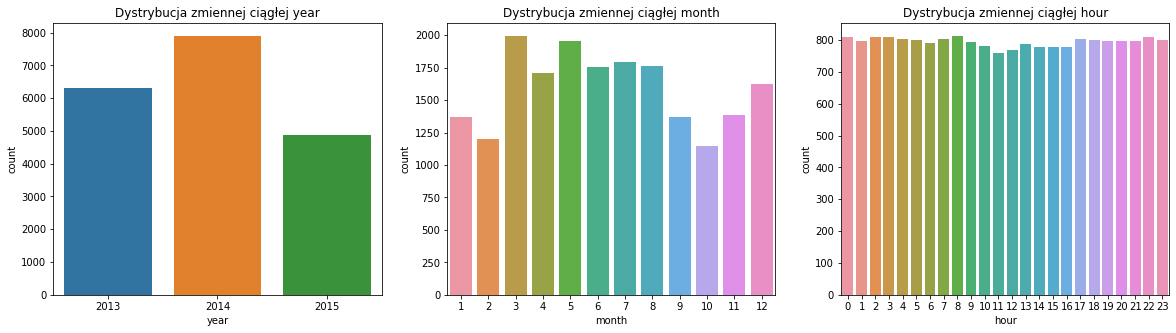

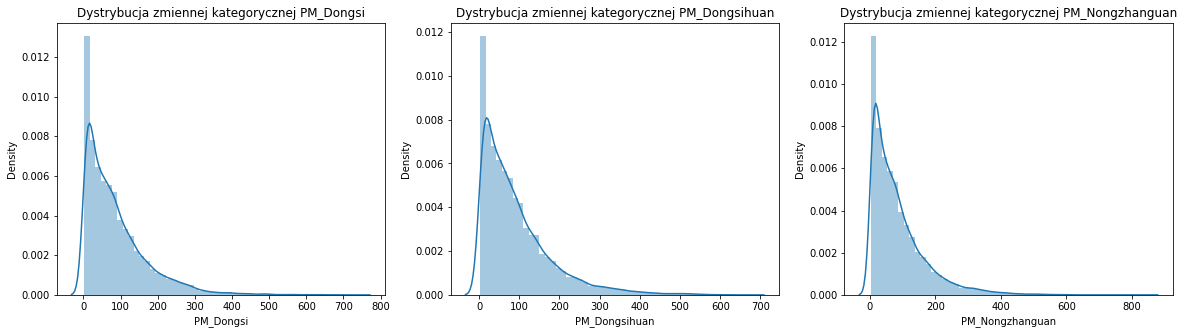

In [9]:
plot_distribution(beijing_after_preprocessing, continuous, categorical, rows = (0,2))

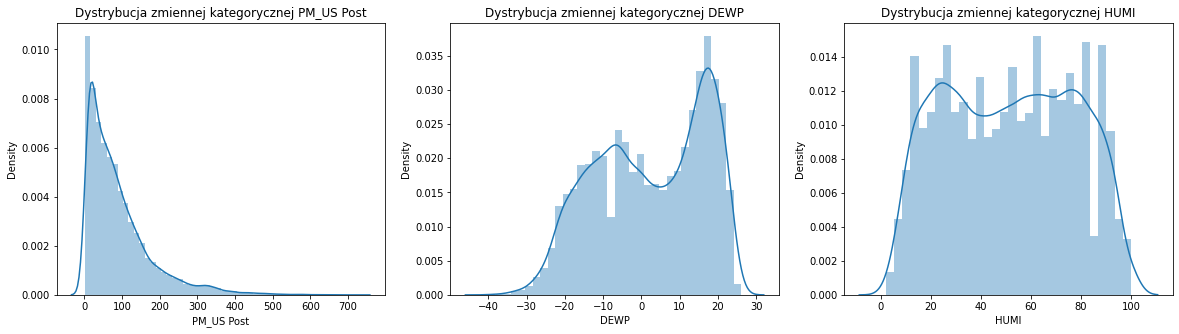

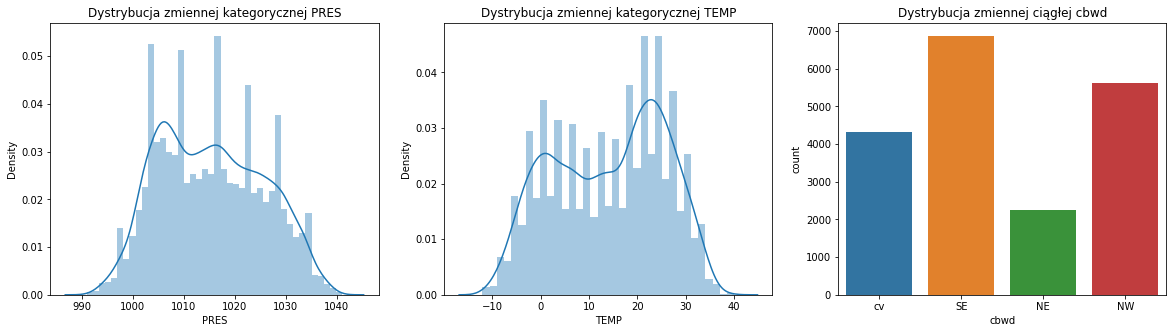

In [10]:
plot_distribution(beijing_after_preprocessing, continuous, categorical, rows = (2,4))

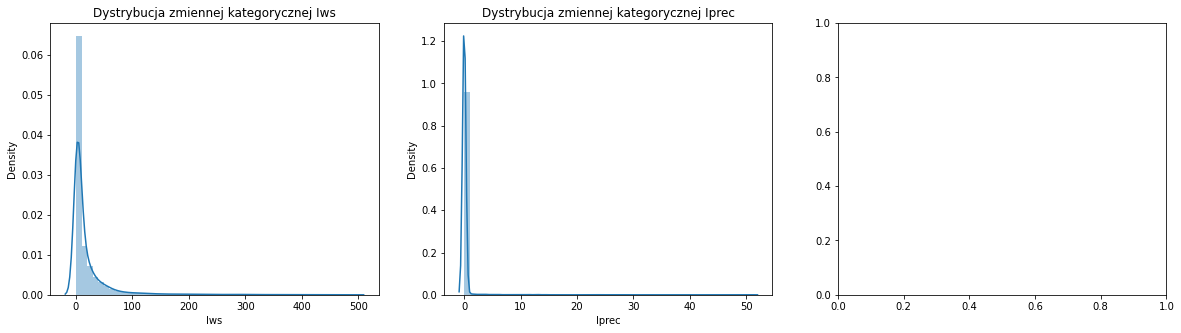

In [11]:
plot_distribution(beijing_after_preprocessing, continuous, categorical, rows = (4,6))

In [12]:
beijing_after_preprocessing[continuous].describe().round(4)

,PM_Dongsi,PM_Dongsihuan,PM_Nongzhanguan,PM_US Post,DEWP,HUMI,PRES,TEMP,Iws,Iprec
count,19062.0000,19062.0000,19062.0000,19062.0000,19062.0000,19062.0000,19062.0000,19062.0000,19062.0000,19062.0000
mean,86.6273,92.2640,85.6595,90.0997,2.3619,51.3623,1015.3520,14.0629,21.0200,0.2158
std,82.9534,87.7066,83.5106,86.1516,14.2667,25.5207,10.2145,11.5275,46.3905,2.1495
min,3.0000,3.0000,3.0000,2.0000,-40.0000,2.0000,991.0000,-12.0000,0.4500,0.0000
25%,25.0000,28.0000,25.0000,27.0000,-10.0000,29.0000,1007.0000,4.0000,1.7900,0.0000
50%,64.0000,68.0000,62.0000,66.0000,3.0000,52.0000,1015.0000,15.0000,4.9200,0.0000
75%,121.0000,128.0000,117.0000,122.0000,16.0000,73.0000,1023.0000,24.0000,19.6700,0.0000
max,737.0000,672.0000,844.0000,722.0000,26.0000,100.0000,1041.0000,40.0000,490.3800,51.1000


 | Nazwa kolumny | Typ zmiennej | Opis rozkładu |
 | --- | --- | --- |
 | `year`| kategoryczna | Najwięcej obserwacji posiadamy z roku 2014, nastepnie w kolejności jest 2013, a najmniej obserwacji jest z 2015 roku. |
 | `month`| kategoryczna | Jeżeli chodzi o rozkład miesięcy jest on sezonowy - w lato jest najwiecej obserwacji natomiast w jesien i przełow zimy z wiosna jest ich najmniej |
 | `hour`| kategoryczna | Rokład danych jest równowmierny | 
 | `PM_X`| ciągłe / predykowane | Zakres danych to *(2, 844)* ze średnia na poziomie około 89. Zbiory są mocno przekrzywiony w lewą stroną (right skewness) oraz posiadają bardzo wysoką wariancję. Mediana zmiennej leży na poziomie 65. Również, można zauważyć, że ta zmienna posiada dużo wartości odstających spowodowanych dystrybucja tych danych. |
 | `DEWP`| ciągła | Zakres danych to *(-40, 26)*, dystrybucja przypomina normalną z dwoma modami - jedna na poziomie *-10*, a druga na poziomie *18*. |
 | `HUMI`| ciągła | Zakres danych to *(2, 100)*, dystrybucja jest równomierna w głównym zakresie, natomiast na brzegach jest ona zmniejszona. |
 | `PRES`| ciągła | Zakres danych to *(991, 1041)*, dystrybucja jest lekko przekrzywiona w lewa strona z modą na wartosci *64*. |
 | `TEMP`| ciągła | Zakres danych to *(-12, 40)*, przypomina miksture dwoch rozkladow normalnych z modami na poziomach *0* i *20* |
 | `cbwd`| kategoryczna | Najczęstszym wiatrem jest wiatr *SE*, natomiast najrzadszym jest *NE*. |
 | `Iws`| ciągła | Zakres danych to *(0.45, 490.38)* i jest ekstremalnie przekrzywiony w lewą strone (extreme right skewness), co może znacząco wpłynąc na korzyść z wykorzystana tej zmiennej |
 | `Iprec`| ciągła | Zakres danych to *(0, 51.1)* i również jest ekstremalnie przekrzywiony w lewą strone (extreme right skewness), co może znacząco wpłynąc na korzyść z wykorzystana tej zmiennej |

### Obserwacje odstające

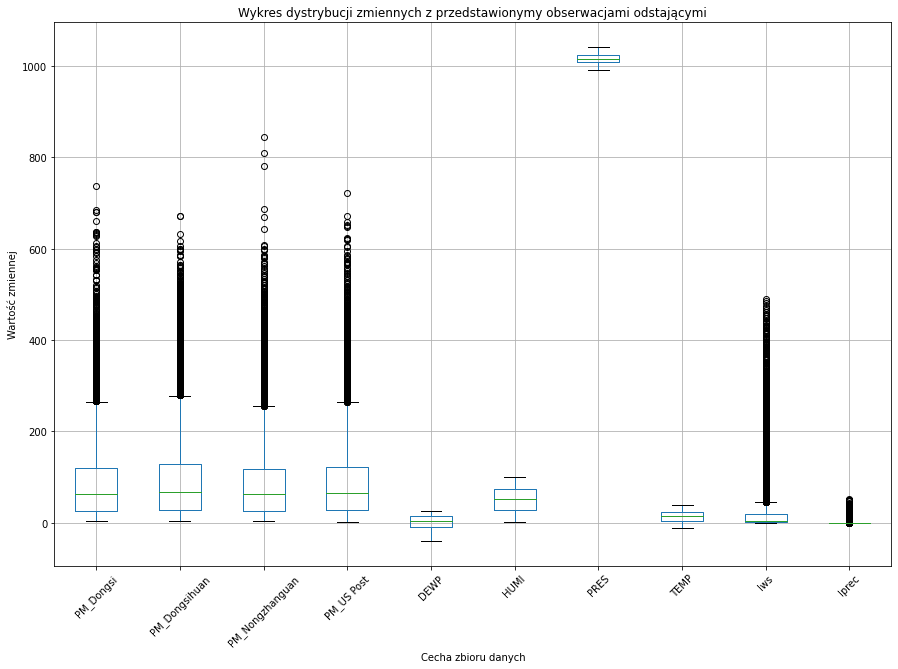

In [13]:
plot_outliers(beijing_after_preprocessing, continuous)

Powyżej można zauważyć, ze tak jak w analizie zmiennych i dystrybucji dane dotyczące pyłów, skumulowanego deszczu oraz sumy deszczu posiadają bardzo dużą ilość wartości odstających per mediana. Ale finalnie uznaliśmy, że zostaną one wszystkie znormalizowane w taki sposób, żeby poprawić ich dystrybucje. 

Na zmiennych posiadające bardzo przekrzywione dystrybucje została zastosowana transformacja logarytmiczna, gdyż jest ona wskazana dla tego typu danych. Ponadto na wszystkich danych została użyta normalizacja standardowa tj. odjecie średniej i podzielenie przez odchylenie standardowe.

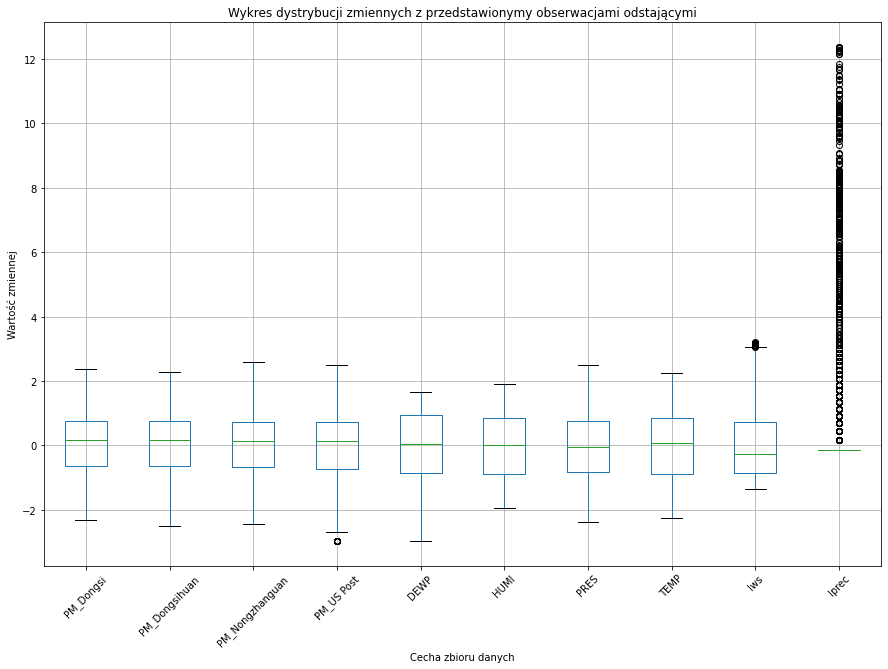

In [14]:
non_problematic_continuous = [ 'DEWP', 'HUMI', 'PRES', 'TEMP']

problematic_continuous = ['PM_Dongsi', 'PM_Dongsihuan', 'PM_Nongzhanguan',
              'PM_US Post', 'Iws', 'Iprec']

transformer = StandardScaler()
beijing_after_scaling_pc = np.log(beijing_after_preprocessing[problematic_continuous] + 1)
beijing_after_scaling_pc = pd.DataFrame(
    transformer.fit_transform(beijing_after_scaling_pc),
    columns = problematic_continuous
)

transformer = StandardScaler()
beijing_after_scaling_npc = pd.DataFrame(
    transformer.fit_transform(beijing_after_preprocessing[non_problematic_continuous]),
    columns = non_problematic_continuous
)

beijing_after_normalization = beijing_after_scaling_pc.join(beijing_after_scaling_npc)

plot_outliers(beijing_after_normalization, continuous)

#### Finalne dane do modeli

In [15]:
final_beijing = beijing_after_normalization.join(beijing_after_preprocessing[categorical].reset_index(drop=True))
final_beijing

,PM_Dongsi,PM_Dongsihuan,PM_Nongzhanguan,PM_US Post,Iws,Iprec,DEWP,HUMI,PRES,TEMP,year,month,hour,cbwd
0,0.713819,0.984191,0.905509,0.942610,-1.144002,-0.144118,-0.586129,0.299281,0.357152,-1.133227,2013,3,8,cv
1,0.814514,0.978585,0.982234,1.024822,-0.842828,-0.144118,-0.726319,-0.523603,0.357152,-0.786221,2013,3,9,cv
2,0.880100,1.022514,0.821954,1.078005,-0.626051,-0.144118,-0.726319,-0.797898,0.259250,-0.525966,2013,3,10,cv
3,1.041736,1.069582,-2.440952,1.128490,-0.317422,-0.144118,-0.796414,-1.111377,0.161347,-0.265711,2013,3,12,cv
4,1.041736,1.000808,-2.440952,1.160779,-0.199362,-0.144118,-0.796414,-1.150562,-0.034457,-0.178960,2013,3,13,cv
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19057,0.728914,0.660044,0.697559,0.671496,-0.094679,-0.144118,-0.866509,0.260096,1.434078,-1.480234,2015,12,18,SE
19058,0.873753,0.932487,0.777214,0.823711,-0.004306,-0.144118,-0.726319,0.651946,1.531980,-1.480234,2015,12,19,SE
19059,0.975991,1.152489,0.963632,1.060591,0.076681,-0.144118,-0.726319,0.456021,1.434078,-1.393482,2015,12,20,SE
19060,1.052241,1.291011,1.219674,1.242087,-1.144002,-0.144118,-0.866509,0.847871,1.434078,-1.740489,2015,12,21,NE


### Korelacje w zbiorze

In [16]:
final_beijing.corr().style.background_gradient(cmap='coolwarm').set_precision(2)

,PM_Dongsi,PM_Dongsihuan,PM_Nongzhanguan,PM_US Post,Iws,Iprec,DEWP,HUMI,PRES,TEMP,year,month,hour
PM_Dongsi,1.00,0.91,0.94,0.94,-0.36,-0.03,0.29,0.46,-0.14,0.01,-0.01,-0.13,0.02
PM_Dongsihuan,0.91,1.00,0.93,0.94,-0.39,-0.03,0.25,0.47,-0.08,-0.05,-0.02,-0.07,-0.03
PM_Nongzhanguan,0.94,0.93,1.00,0.95,-0.37,-0.03,0.25,0.46,-0.08,-0.05,-0.00,-0.09,-0.01
PM_US Post,0.94,0.94,0.95,1.00,-0.37,-0.02,0.23,0.47,-0.06,-0.08,-0.05,-0.09,-0.00
Iws,-0.36,-0.39,-0.37,-0.37,1.00,-0.01,-0.24,-0.40,0.07,-0.00,-0.00,-0.02,0.17
Iprec,-0.03,-0.03,-0.03,-0.02,-0.01,1.00,0.13,0.20,-0.10,0.05,-0.03,0.01,-0.01
DEWP,0.29,0.25,0.25,0.23,-0.24,0.13,1.00,0.66,-0.77,0.80,-0.05,0.17,-0.03
HUMI,0.46,0.47,0.46,0.47,-0.40,0.20,0.66,1.00,-0.29,0.10,-0.01,0.15,-0.28
PRES,-0.14,-0.08,-0.08,-0.06,0.07,-0.10,-0.77,-0.29,1.00,-0.82,0.06,-0.01,-0.05
TEMP,0.01,-0.05,-0.05,-0.08,-0.00,0.05,0.80,0.10,-0.82,1.00,-0.06,0.11,0.17


Analizując macierz korelacji, możemy zauważyć i całkiem słusznie, że wszystkie pomiary ilości pyłów (*PM_X*) są ze sobą silnie skorelowane, co intuicyjnie ma sens ze wzgledu na lokalizacje czujników. Ponadto ważną korelacją jest równiez korelacja negatywna pyłów (*PM_X*) a siłą wiatru (*Iws*). Również jest pozytywna zależność pomiedzy punktem rosy (*DEWP*) a pyłami (*PM_X*). Do tego jest silna pozytywna korelacja pomiedzy wilgotnością powietrza (*HUMI*) a zawartością pyłów (*PM_X*). 

Również punkt rosy jest silnie skorelowany z wilgotnością, ciśnieniem atmosferycznych oraz temperatura. Ciekawą korelają jest również godzina (*hour*) z wilgotnością powietrza (*HUMI*).

Ostatnią istotną korelacja jest korelacja pomiędzy ciśnieniem, a temperaturą.

## Modele

### Proste modele probabilistyczne

In [32]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split

features = ['DEWP', 'HUMI', 'PRES', 'TEMP', 'Iws', 'Iprec', 'year', 'month', 'hour']
target = ['PM_Dongsihuan']

features.extend([f'wind_direction_{i}' for i in final_beijing['cbwd'].unique()])

one_hot = OneHotEncoder(drop=None, sparse=False)
onehot_beijing = final_beijing.join(pd.DataFrame(
    one_hot.fit_transform(final_beijing['cbwd'].to_numpy().reshape(-1, 1)),
    columns=[f'wind_direction_{i}' for i in final_beijing['cbwd'].unique()],
    index=final_beijing.index,
))

X_train, X_test, y_train, y_test = train_test_split(onehot_beijing[features],
                                                    onehot_beijing[target],
                                                    test_size=0.2,
                                                    random_state=42)
ridge_regression = linear_model.Ridge(
    alpha=1.0,
    fit_intercept=True,
    normalize=False
)

ridge_regression.fit(X_train[features], y_train[target])
print(ridge_regression.score(X_train[features], y_train[target]))

print(ridge_regression.score(X_test[features], y_test[target]))

0.43770419714057474
0.43618316064481877


In [61]:
from sklearn.linear_model import BayesianRidge
from sklearn.metrics import r2_score

bayes_ridge = BayesianRidge()

bayes_ridge.fit(X_train[features], y_train[target])

print(bayes_ridge.score(X_train[features], y_train[target]))
print(bayes_ridge.score(X_test[features], y_test[target]))

r2_score(y_test[target], bayes_ridge.predict(X_test[features]))

0.437701318134352
0.43618693773802386


0.43618693773802386

array([-0.06856872,  0.15848348,  0.16712281, ..., -0.01507611,
       -0.88725198, -0.76071805])

In [58]:
online_model = FullConjugateBayesLinReg(len(features), alpha_init=.2)

online_model.fit(X_train, y_train)

y_pred = online_model.predict(X_test).pdf(.9999)

r2_score(y_test, y_pred)

0.13148445848171142

In [126]:
class OnlineModel(FullConjugateBayesLinReg):
    def __init__(
        self,
        n_features,
        n_iter=300,
        tol=1.e-3,
        alpha_shape=1.e-6, # non-informative prior 
        alpha_rate=1.e-6,
        lmbda_shape=2, # mode=1 => standard normal posterior
        lmbda_rate=1,
        alpha_init=None,
        lmbda_init=1,
        fit_intercept=False
    ):
        FullConjugateBayesLinReg.__init__(self, n_features, n_iter, tol, alpha_shape,
                                          alpha_rate, lmbda_shape, lmbda_rate, alpha_init,
                                          lmbda_init, fit_intercept)
    
    def model_fit(self, i, X_train, y_train):
        self.fit(X_train[:i], y_train[:i])

In [135]:
online_model = OnlineModel(len(features), alpha_init=.2)

rs_train, rs_test = [], []

from tqdm.auto import tqdm

batch_size = 32

for i in tqdm(range(batch_size, len(X_train) + 1, batch_size)):
    online_model.model_fit(i, X_train, y_train)
    
    y_pred = online_model.predict(X_train).pdf(.9999)
    rs_train.append(r2_score(y_train, y_pred))
    
    y_pred = online_model.predict(X_test).pdf(.9999)
    rs_test.append(r2_score(y_test, y_pred))
    
    


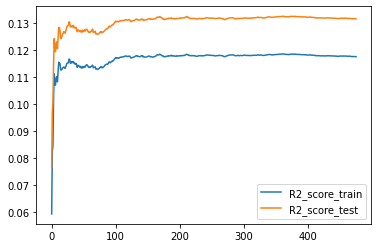

In [136]:
plt.plot(range(len(rs_train)), rs_train, label='R2_score_train')
plt.plot(range(len(rs_test)), rs_test, label='R2_score_test')
plt.legend()

In [121]:
y_train[:5]

,PM_Dongsihuan
16771,0.792546
16622,-0.557878
1714,0.089043
9838,-0.349616
8492,0.594521


### Probabilistyczne Modele Grafowe

W tej części będziemy wnioskować zawartość pyłów w powietrzu na podstawie danych metereologicznych. Zakładamy uproszczony model, że każda z zmiennych jest niezależna od siebie, pomimo, że z korelacji wynika, że są ze sobą związane.

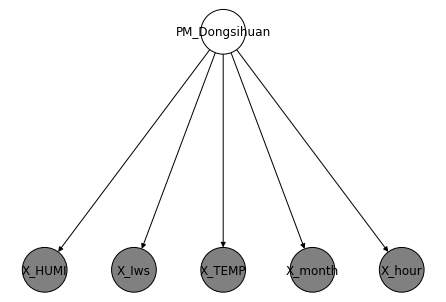

In [137]:
import networkx as nx
    
g = nx.DiGraph()
g.add_edges_from([("PM_Dongsihuan", "X_HUMI"), ("PM_Dongsihuan", "X_Iws"), ("PM_Dongsihuan", "X_TEMP"), ("PM_Dongsihuan", "X_month"), ("PM_Dongsihuan", "X_hour")])

nx.draw(
    g, 
    with_labels=True, 
    node_color=["gray" if "X" in v else "white" for v in g.nodes()],
    pos={"PM_Dongsihuan": (0, 0), "X_HUMI": (-2, -1), "X_Iws": (-1, -1),"X_TEMP": (0, -1), "X_month": (1, -1), "X_hour": (2, -1)},
    edgecolors="black",
    node_size=2000,
)

## Eksperymenty

### Zastosowanie prostych modeli probabilistycznych

### Zastosowanie graficznego modelu probabilistycznego

### Porównianie wyników wybranych modeli

## Kody pomocnicze do raportu

In [19]:
def plot_distribution(dataset, continuous, categorical, rows = None):
    """Metoda pomocnicza do rysowania wykresów dystrybucji danych.
    
    Keyword arguments:
    dataset -- zbiór danych, którego dystrybucje chcemy narysować
    continuous -- lista nazw zmiennych ciągłych zdefiniowanych przez użytkownika
    categorical -- lista nazw zmiennych kategorycznych zdefiniowanych przez użytkownika
    """
    
    max_rows = math.ceil(len(dataset.columns) / 3)
    
    assert rows[0] <= rows[1]
    
    if rows is None:
        rows = (0, max_rows)
    else:
        if rows[0] > max_rows:
            return
    fig, ax = None, ()
    i, row = 0, 0
    for col in dataset.columns:
        if row >= rows[0] and row < rows[1]:
            if i % 3 == 0:
                fig, ax = plt.subplots(1, 3, figsize=(20,5))
            if col in continuous:
                sns.distplot(dataset[col], ax = ax[i % 3]).set_title("Dystrybucja zmiennej kategorycznej " + str(col))
            elif col in categorical:
                sns.countplot(dataset[col], ax = ax[i % 3]).set_title("Dystrybucja zmiennej ciągłej " + str(col))
            i += 1
            if i % 3 == 0:
                fig.show()
                row += 1
        else:
            i += 1
            if i % 3 == 0:
                row += 1

def plot_outliers(dataset, continuous):
    """Metoda pomocnicza do rysowania wykresów z obserwacjami odstającymi.
    
    Keyword arguments:
    dataset -- zbiór danych, którego dystrybucje chcemy narysować
    continuous -- lista nazw zmiennych ciągłych zdefiniowanych przez użytkownika
    """
    dataset.boxplot(column=continuous, figsize = (15,10))
    plt.xticks(rotation = 45)
    plt.title("Wykres dystrybucji zmiennych z przedstawionymy obserwacjami odstającymi")
    plt.xlabel("Cecha zbioru danych")
    plt.ylabel("Wartość zmiennej")
    plt.show()

In [20]:
from matplotlib.animation import FuncAnimation

class UpdateBayesianLinearRegression:
    '''Pomocnicza klasa do inkrementalnego uczenia'''
    def __init__(
        self,
        ax,
        model,
        X_test_with_cat,
        y_test,
        x_idx,
        x_label,
        y_label,
        category_idx=None,
        interval=0.95
    ):
        self.ax = ax
        self.model = model
        self.x_idx = x_idx
        
        self.interval = interval
        
        self.mean, = ax.plot([], [], color="red", label="Mean output")
        self.credible_interval = ax.fill_between(
            [],
            [],
            [],
            color='cornflowerblue',
            alpha=0.5,
            label=f"Credible Interval"
        )
        self.num_samples = ax.text(0.5, 1, '', fontsize=15, horizontalalignment='right',
                                   verticalalignment='bottom', transform=ax.transAxes)
        self.ratio_in_interval = ax.text(1, 0, '', fontsize=15, horizontalalignment='right',
                           verticalalignment='bottom', transform=ax.transAxes)
        
        if category_idx is not None:
            for cat in np.unique(X_test_with_cat[:, category_idx]):
                mask = X_test_with_cat[:, category_idx] == cat
                self.ax.scatter(
                    X_test_with_cat[mask, x_idx], y_test[mask],
                    marker='+', s=100,
                    alpha=1,
                    label=cat
                )
        else:
            self.ax.scatter(
                X_test_with_cat[:, x_idx], y_test,
                marker='+', s=100,
                alpha=1,
            )
        
        # Set up plot parameters
        self.ax.set_xlim(
            np.min(X_test_with_cat[:, x_idx])-0.2,
            np.max(X_test_with_cat[:, x_idx])+0.2
        )
        self.ax.set_xlabel(x_label)
        self.ax.set_ylabel(y_label)
        
        # Set up legend
        handles, labels = self.ax.get_legend_handles_labels()
        fig.legend(handles[:2], labels[:2], loc='upper right')
        if category_idx is not None:
            fig.legend(handles[2:], labels[2:], loc='lower right', title='Category')
        
    
    def model_fit(self, i, X_train, y_train):
        self.model.fit(X_train[i-1, :], y_train[i-1])

    def __call__(self, i, X_train, y_train, X_test, y_test):
        
        # This way the plot can continuously run and we just keep
        # watching new realizations of the process
        if i != 0:
            self.model_fit(i, X_train, y_train)

        predictive = self.model.predict(X_test)
        predictive_mean = predictive.mean()
        lower_interval, upper_interval = predictive.interval(self.interval)
        ci_ratio = np.sum(
            (lower_interval <= y_test) &
            (y_test <= upper_interval)
        ) / len(y_test)
        
        self.ax.set_ylim(
            min(np.min(lower_interval), np.min(y_test))-0.5,
            max(np.max(upper_interval), np.max(y_test))+0.5,
        )
        
        
        self.credible_interval.remove()
        self.credible_interval = self.ax.fill_between(
            X_test[:, self.x_idx],
            lower_interval,
            upper_interval,
            color='cornflowerblue',
            alpha=0.5,
            label=f"Credible Interval"
        )
        
        self.mean.set_data(X_test[:, self.x_idx], predictive_mean)
        self.num_samples.set_text(f'Number of train samples: {i}')
        self.ratio_in_interval.set_text(f'Percent of observations within CI: {ci_ratio*100:.2f}%')
        return self.mean, self.credible_interval, self.num_samples

In [73]:
class ConjugateBayesLinReg:

    def __init__(self, n_features, alpha, lmbda, intercept=0):
        self.n_features = n_features
        self.alpha = alpha
        self.lmbda = lmbda
        self.mean = np.zeros(n_features)
        self.cov_inv = np.identity(n_features) / alpha
        self.cov = np.linalg.inv(self.cov_inv)
        self.intercept = intercept

    def fit(self, x, y):
        
        # If x and y are singletons, then we coerce them to a batch of length 1
        x = np.atleast_2d(x)
        y = np.atleast_1d(y)

        # Update the inverse covariance matrix (Bishop eq. 3.51)
        cov_inv = self.cov_inv + self.lmbda * x.T @ x

        # Update the mean vector (Bishop eq. 3.50)
        cov = np.linalg.inv(cov_inv)
        
        mean = cov @ (self.cov_inv @ self.mean + self.lmbda * y @ x)

        self.cov_inv = cov_inv
        self.cov = cov
        self.mean = mean


    def predict(self, x):
        '''Metoda zwraca rozkład predykcyjny zmiennej niezależnej na bazie bieżących parametrów modelu.'''
        # If x and y are singletons, then we coerce them to a batch of length 1
        x = np.atleast_2d(x)
        
#         print(x.shape)
#         print(1/self.lmbda)
#         print(self.cov.shape)
#         print((x @ self.cov).shape)
#         print((x @ self.cov @ x.T).shape)
        # TU WPISZ KOD
        y_pred_var = np.diagonal((1/self.lmbda) + x @ self.cov @ x.T)
        y_pred_mean = x @ self.mean + self.intercept
        
        
        # Drop a dimension from the mean and variance in case x and y were singletons
        y_pred_mean = np.squeeze(y_pred_mean)
        y_pred_var = np.squeeze(y_pred_var)

        return stats.norm(loc=y_pred_mean, scale=y_pred_var ** .5)

    @property
    def weights_dist(self):
        return stats.multivariate_normal(mean=self.mean, cov=self.cov)

In [25]:
from scipy import stats

class FullConjugateBayesLinReg(ConjugateBayesLinReg):

    def __init__(
        self,
        n_features,
        n_iter=300,
        tol=1.e-3,
        alpha_shape=1.e-6, # non-informative prior 
        alpha_rate=1.e-6,
        lmbda_shape=2, # mode=1 => standard normal posterior
        lmbda_rate=1,
        alpha_init=None,
        lmbda_init=1,
        fit_intercept=False
    ):
        self.n_iter = n_iter
        self.tol = tol
        self.alpha_shape = alpha_shape
        self.alpha_rate = alpha_rate
        self.lmbda_shape = lmbda_shape
        self.lmbda_rate = lmbda_rate
        self.alpha = alpha_init
        self.lmbda = lmbda_init
        self.fit_intercept = fit_intercept
        
        self.mean = np.zeros((n_features,))
        self.cov = np.eye(n_features) / self.alpha
        self.intercept = 0

    def fit(self, x, y):
        
        # If x and y are singletons, then we coerce them to a batch of length 1
        x = np.atleast_2d(x)
        y = np.atleast_1d(y)

        model = BayesianRidge(
            n_iter=self.n_iter,
            tol=self.tol,
            alpha_1=self.lmbda_shape,
            alpha_2=self.lmbda_rate,
            lambda_1=self.alpha_shape,
            lambda_2=self.alpha_rate,
            alpha_init=self.lmbda,
            lambda_init=self.alpha,
            fit_intercept=self.fit_intercept,
            normalize=False,
        )
        
        model.fit(x, y)
        
        self.mean = model.coef_
        self.cov = model.sigma_
        self.alpha = model.lambda_
        self.lmbda = model.alpha_
        self.intercept = model.intercept_

In [27]:
class UpdateBayesianLinearRegressionInreasingWindow(UpdateBayesianLinearRegression):
    def model_fit(self, i, X_train, y_train):
        self.model.fit(X_train[:i, :], y_train[:i])